## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
import sklearn.model_selection as skl
from random import sample
import scipy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, f1_score

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
18074  00004837_005.png     No Finding            5        4837           49   
59905  00014790_013.png     No Finding           13       14790           67   
29619  00007712_003.png     No Finding            3        7712           81   

      Patient Gender View Position  OriginalImage[Width  Height]  \
18074              F            AP                 2500     2048   
59905              M            PA                 2874     2921   
29619              F            PA                 2894     2673   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
18074                        0.171  0.171          NaN   
59905                        0.143  0.143          NaN   
29619                        0.143  0.143          NaN   

                                           path  
18074  /data/images_003/images/00004837_005.png  
59905  /data/images_007/images/00014790_013.png  
29619  /data/images_004/images/00007712_003.png

In [3]:
## One-Hot encoding for ML application

all_labels=np.unique(list(chain(*all_xray_df['Finding Labels'].apply(lambda x: x.split('|')).tolist())))
all_labels=[x for x in all_labels if len(x)>0]
print(all_labels)

for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].apply(lambda finding: 1.0 if label in finding else 0)

        
all_xray_df.head()

['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis Hernia  Infiltration  \
0                        0.143  ...        0.0       0.0    0.0           0.0   
1                        0.143  ...        1.0       0.0    0.0           0.0   
2                        0.168  ...        0.0       0.0    0.0           0.0   
3                        0.171  ...        0.0       0.0    0.0           0.0   
4                        0.143  ...        0.0       0.0    1.0           0.0   

   Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
0   0.0         0.0     0.0                 0.0        0.0           0.0  
1   0.0         0.0     0.0                 0.0        0.0           0.0  
2   0.0         0.0     0.0                 0.0        0.0           0.0  
3   0.0         1.0     0.0                 0.0        0.0           0.0  
4   0.0         0.0     0.0                 0.0        0.0           0.0  

[5 rows x 28 columns]

In [4]:
## pneumonia_class: images with or without pneumonia for binary classification

all_xray_df['pneumonia_class']=all_xray_df['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})
all_xray_df[all_xray_df['pneumonia_class']== 'Positive']

Image Index                                     Finding Labels  \
48      00000013_010.png                    Effusion|Pneumonia|Pneumothorax   
126     00000032_012.png          Atelectasis|Consolidation|Edema|Pneumonia   
253     00000056_000.png                                   Nodule|Pneumonia   
276     00000061_012.png  Edema|Effusion|Infiltration|Pleural_Thickening...   
279     00000061_015.png                                          Pneumonia   
...                  ...                                                ...   
111557  00030536_007.png                Atelectasis|Consolidation|Pneumonia   
111627  00030570_001.png                       Edema|Infiltration|Pneumonia   
111767  00030621_002.png                                          Pneumonia   
111845  00030637_016.png                            Consolidation|Pneumonia   
112115  00030801_001.png                                     Mass|Pneumonia   

        Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
48               10          13           60              M            AP   
126              12          32           55              F            AP   
253               0          56           76              M            PA   
276              12          61           77              M            AP   
279              15          61           77              M            AP   
...             ...         ...          ...            ...           ...   
111557            7       30536           56              F            AP   
111627            1       30570           29              F            AP   
111767            2       30621           22              F            AP   
111845           16       30637           48              M            AP   
112115            1       30801           39              M            PA   

        OriginalImage[Width  Height]  OriginalImagePixelSpacing[x  ...  \
48                     3056     2544                        0.139  ...   
126                    2500     2048                        0.168  ...   
253                    2500     2048                        0.168  ...   
276                    3056     2544                        0.139  ...   
279                    3056     2544                        0.139  ...   
...                     ...      ...                          ...  ...   
111557                 3056     2544                        0.139  ...   
111627                 3056     2544                        0.139  ...   
111767                 3056     2544                        0.139  ...   
111845                 3056     2544                        0.139  ...   
112115                 2048     2500                        0.168  ...   

        Fibrosis  Hernia Infiltration  Mass  No Finding  Nodule  \
48           0.0     0.0          0.0   0.0         0.0     0.0   
126          0.0     0.0          0.0   0.0         0.0     0.0   
253          0.0     0.0          0.0   0.0         0.0     1.0   
276          0.0     0.0          1.0   0.0         0.0     0.0   
279          0.0     0.0          0.0   0.0         0.0     0.0   
...          ...     ...          ...   ...         ...     ...   
111557       0.0     0.0          0.0   0.0         0.0     0.0   
111627       0.0     0.0          1.0   0.0         0.0     0.0   
111767       0.0     0.0          0.0   0.0         0.0     0.0   
111845       0.0     0.0          0.0   0.0         0.0     0.0   
112115       0.0     0.0          0.0   1.0         0.0     0.0   

        Pleural_Thickening  Pneumonia  Pneumothorax  pneumonia_class  
48                     0.0        1.0           1.0         Positive  
126                    0.0        1.0           0.0         Positive  
253                    0.0        1.0           0.0         Positive  
276                    1.0        1.0           0.0         Positive  
279                    0.0        1.0           0.0         Positive  
...                

## Create your training and testing data:

Based on the EDA work, the Data_Entry_2017.csv contains 1,431 images positive for Pneumonia and 110,689 images negative for Pneumonia.

The dataset will be split into 80% Training data and 20% for testing data <br>
Training set: (True: 1431 * 0.8 = 1144.8, False: 110689 * 0.8 = 88551.2) <br>
Validation set: (True: 1431 * 0.2 = 286.2, False: 110689 * 0.2 = 22137.8)

For the training dataset, the positive to negative images must be **equal** in number.
Demographics suvh as age and gender must reflect the general dataset. 
Pneumonia Positive = 1144.8 counts, Pneumonia Negative = 1144.8 counts.

For the validation data set, positive to negative Pneumonia cases, as well as demographics, must reflect the general data set.
Pneumonia Positive =286.2 counts, Pneumonia Negative = 22,137.8 counts

In [5]:

def create_splits(df_name):
    
    ## Split the original dataframe into training set (80%) and validation set (20%) 
    ## Balanced or imbalanced dataset for presence of pneumonia
    
    train_data, val_data = skl.train_test_split(df_name, 
                                                test_size = 0.2,
#                                                 random_state = 10,
                                                stratify = df_name['Pneumonia'])
    
    # Balance the train_data (True:False = 50:50)
    tp_ind = train_data[train_data['pneumonia_class']=='Positive'].index.tolist()
    tn_ind = train_data[train_data['pneumonia_class']=='Negative'].index.tolist()
    tn_sample = sample(tn_ind, len(tp_ind))
    train_data = train_data.loc[tp_ind + tn_sample]
    
    # Balance the val_data (True:False = 20:80)
    # The prevalence of Pneumonia is about 20% of those who are x-rayed
    vp_ind=val_data[val_data['pneumonia_class']=='Positive'].index.tolist()
    vn_ind=val_data[val_data['pneumonia_class']=='Negative'].index.tolist()
    vn_sample = sample(vn_ind,4*len(vp_ind))
    val_data=val_data.loc[vp_ind+vn_sample]
    
    return train_data, val_data

In [6]:
train_data, val_data = create_splits(all_xray_df)

In [7]:
(train_data['pneumonia_class']=='Positive').value_counts()

True     1145
False    1145
Name: pneumonia_class, dtype: int64

In [8]:
(val_data['pneumonia_class']=='Negative').value_counts()

True     1144
False     286
Name: pneumonia_class, dtype: int64

### train_data and val_data have the correct number of Pneuominia-positive and Pneumonia-negative cases in each set.

In [9]:
#check train_data distribution for changes in Age distribution of Males with Pneumonia

scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
                     train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='M')]
                     )

Ttest_indResult(statistic=0.21334298669000792, pvalue=0.8310880571739963)

In [10]:
#check train_data distribution for changes in Age distribution of Females with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='F')],
                     train_data['Patient Age'][(train_data['Pneumonia']==True) & (train_data['Patient Gender']=='F')]
)

Ttest_indResult(statistic=-0.2618534430212985, pvalue=0.793485694811324)

In [11]:
train_constitute = round(100*len(train_data[train_data['Patient Gender']=='M'])/len(train_data), 1)
print('The training dataset is constituted by {} Male ({}%) and {} Female ({}%)'
      .format(len(train_data[train_data['Patient Gender']=='M']), 
              train_constitute,
              len(train_data[train_data['Patient Gender']=='F']),
              100-train_constitute))

The training dataset is constituted by 1342 Male (58.6%) and 948 Female (41.4%)


In [12]:

overall_constitute = round(100*len(all_xray_df[all_xray_df['Patient Gender']=='M'])/len(all_xray_df), 1)
print('The overall dataset is constituted by {} Male ({}%) and {} Female ({}%)'
      .format(len(all_xray_df[all_xray_df['Patient Gender']=='M']), 
              overall_constitute,
              len(all_xray_df[all_xray_df['Patient Gender']=='F']),
              100-overall_constitute))

The overall dataset is constituted by 63340 Male (56.5%) and 48780 Female (43.5%)


In [13]:
#check val_data distribution for changes in Age distribution of Males with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']==True) & (all_xray_df['Patient Gender']=='M')],
                     val_data['Patient Age'][(val_data['Pneumonia']== True) & (val_data['Patient Gender']=='M')])

Ttest_indResult(statistic=-0.5846748093145943, pvalue=0.5588996115801875)

In [14]:
#check val_data distribution for changes in Age distribution of Females with Pneumonia
scipy.stats.ttest_ind(all_xray_df['Patient Age'][(all_xray_df['Pneumonia']== True) & (all_xray_df['Patient Gender']=='F')],
                     val_data['Patient Age'][(val_data['Pneumonia']==True) & (val_data['Patient Gender']=='F')]
)

Ttest_indResult(statistic=0.5845174341825942, pvalue=0.5590545826773157)

In [15]:
val_constitute = round(100*len(val_data[val_data['Patient Gender']=='M'])/len(val_data), 1)
print('The validation dataset is constituted by {} Male ({}%) and {} Female ({}%)'
      .format(len(val_data[val_data['Patient Gender']=='M']), 
              val_constitute,
              len(val_data[val_data['Patient Gender']=='F']),
              100-val_constitute))

The validation dataset is constituted by 765 Male (53.5%) and 665 Female (46.5%)


#### The overall dataset is constituted by 56.5% Male and 43.5% Female. The validation dataset is constituted by 57.3% Male and 42.7% Female.

# Building and Training the model

### Image augmentation

In [16]:

def my_image_augmentation_train():
    
    my_train_idg = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      height_shift_range = 0.1,
                                      width_shift_range = 0.1,
                                      rotation_range = 15,
                                      shear_range = 0.1,
                                      zoom_range = 0.1, 
                                      samplewise_center = True,
                                      samplewise_std_normalization = True
                                     )
    return my_train_idg

def my_image_augmentation_val():
    my_val_idg = ImageDataGenerator(rescale = 1./255.,
                                   samplewise_center=True,
                                   samplewise_std_normalization=True
                                   )
    return my_val_idg

def make_train_gen(my_train_idg, train_df):
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = (224,224), 
                                         batch_size = 16
                                         )

    return train_gen


def make_val_gen(my_val_idg, val_df):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = (224,224), 
                                             batch_size = 32,
                                             shuffle=False
                                            ) 
    
    return val_gen

In [17]:
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen = make_val_gen(my_image_augmentation_val(),val_data)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


### Examples of Augmented Training Data

Found 2290 validated image filenames belonging to 2 classes.
Batch Mean: 9.934108e-09 Batch Std: 0.9999949


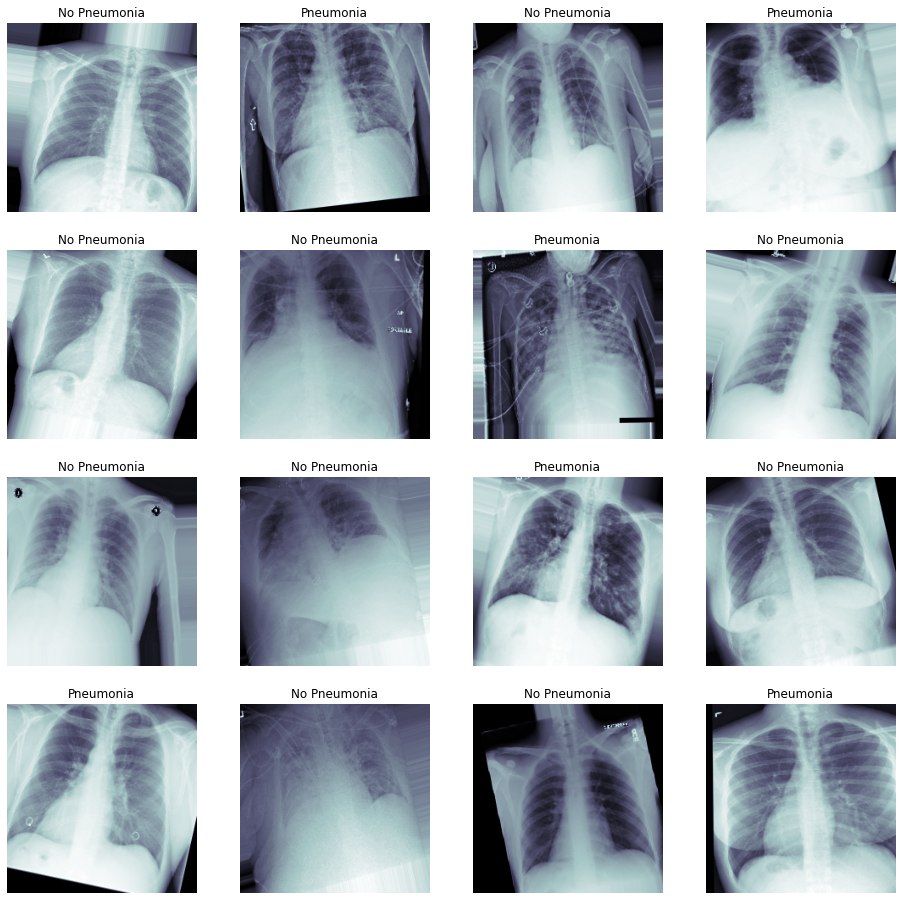

In [18]:
train_idg = my_image_augmentation_train()
train_gen = make_train_gen(train_idg, train_data)

t_x, t_y = next(train_gen)
print("Batch Mean: " + str(t_x.mean()) + " Batch Std: " + str(t_x.std()))
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build the model based on a pre-trained network downloaded from Keras for fine-tuning: 

In [19]:

def load_pretrained_model(layer_of_interest):
    
    model = VGG16(include_top = True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:-2]:
        layer.trainable = False
    
    return vgg_model


In [20]:

def build_my_model(pretrained_model):
   
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



In [21]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting


weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=10)

callbacks_list = [checkpoint, early]

### Start training! 

Here, we will trained 3 models

In [22]:
## train your model

vgg_model = load_pretrained_model('block5_pool')
my_model = build_my_model(vgg_model)

history = my_model.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs = 10, 
                          callbacks = callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 144 steps, validate for 45 steps
Epoch 1/10
143/144 [============================>.] - ETA: 0s - loss: 0.7843 - binary_accuracy: 0.5220
Epoch 00001: val_loss improved from inf to 0.59885, saving model to xray_class_my_model.best.hdf5
144/144 [==============================] - 96s 664ms/step - loss: 0.7836 - binary_accuracy: 0.5218 - val_loss: 0.5988 - val_binary_accuracy: 0.7909
Epoch 2/10
143/144 [============================>.] - ETA: 0s - loss: 0.6867 - binary_accuracy: 0.5611
Epoch 00002: val_loss improved from 0.59885 to 0.59303, saving model to xray_class_my_model.best.hdf5
144/144 [==============================] - 82s 572ms/step - loss: 0.6865 - binary_accuracy: 0.5620 - val_loss: 0.5930 - val_binary_accuracy: 0.6497
Epoch 3/10
143/144 [============================>.] - ETA: 0s - loss: 0.6792 - binary_accuracy: 0.6033
Epoch 00003: val_loss impr

In [23]:
def plot_history(history,epoch):
    plt.style.use('ggplot')
    plt.figure(figsize=(12,12))
    plt.style.use('ggplot')
    plt.plot(range(epoch),history.history['loss'],label='Loss', color='green')
    plt.plot(range(epoch),history.history['val_loss'],label='Validation_Loss', color = 'red')
    plt.plot(range(epoch),history.history['binary_accuracy'],label='Binary_Accuracy',color='blue')
    plt.plot(range(epoch),history.history['val_binary_accuracy'],label='Validation_Bin_Accuracy',color='purple')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss/Accuracy')
    plt.savefig('Output/Model_Training_Performance')
    plt.show()

    return

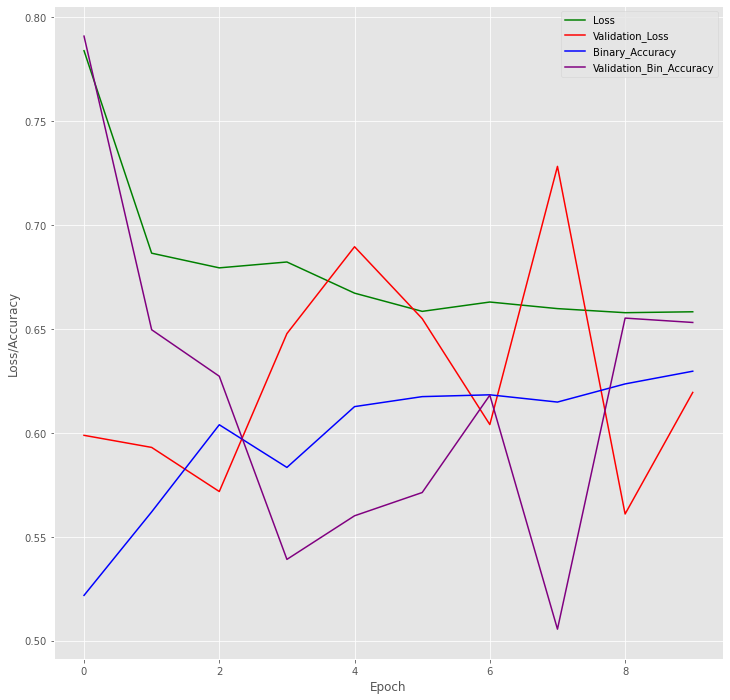

In [24]:
plot_history(history,10)

In [25]:
performance = []
history_df=pd.DataFrame(history.history)
performance.append(history_df[history_df['val_loss']==min(history_df['val_loss'])])
performance

[       loss  binary_accuracy  val_loss  val_binary_accuracy
 8  0.657849         0.623581  0.560996             0.655245]

### Build 2nd model

In [26]:
def build_my_model2(pretrained_model):
    "Add one Dense layer and one Dropout Layer"
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    
    # addition added Dense layer and Dropout layer
    my_model.add(Dense(2048, activation = 'relu'))
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
     
    return my_model

In [27]:
#Train Model #2 with Dense and Dropout Layer
vgg_model = load_pretrained_model('block5_pool')
my_model2 = build_my_model2(vgg_model)
history2 = my_model2.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 144 steps, validate for 45 steps
Epoch 1/10
143/144 [============================>.] - ETA: 0s - loss: 0.8101 - binary_accuracy: 0.5000
Epoch 00001: val_loss did not improve from 0.56100
144/144 [==============================] - 81s 561ms/step - loss: 0.8093 - binary_accuracy: 0.5009 - val_loss: 0.6679 - val_binary_accuracy: 0.4573
Epoch 2/10
143/144 [============================>.] - ETA: 0s - loss: 0.6917 - binary_accuracy: 0.5400
Epoch 00002: val_loss did not improve from 0.56100
144/144 [==============================] - 80s 556ms/step - loss: 0.6901 - binary_accuracy: 0.5424 - val_loss: 0.5759 - val_binary_accuracy: 0.6098
Epoch 3/10
143/144 [============================>.] - ETA: 0s - loss: 0.6980 - binary_accuracy: 0.5097
Epoch 00003: val_loss did not improve from 0.56100
144/144 [==============================] - 80s 558ms/step - loss: 0.6979 - binary_accuracy: 0.5105 - val_loss: 0.7400 - val_binary_accuracy: 0.2000
E

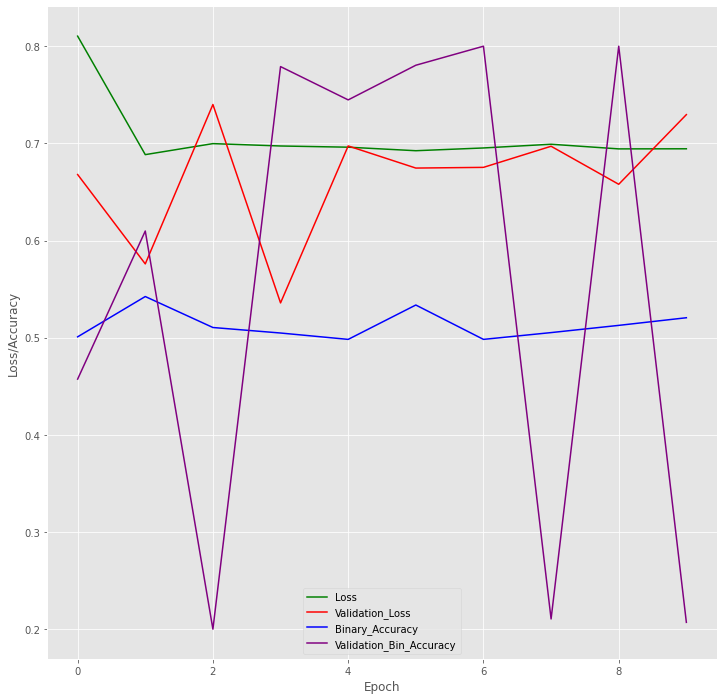

In [28]:
plot_history(history2,10)

In [29]:
history2_df=pd.DataFrame(history2.history)
performance.append(history2_df[history2_df['val_loss']==min(history2_df['val_loss'])])
performance

[       loss  binary_accuracy  val_loss  val_binary_accuracy
 8  0.657849         0.623581  0.560996             0.655245,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 3  0.697308         0.504803  0.535796             0.779021]

### Build 3rd model

In [30]:
def build_my_model3(pretrained_model):
    "Change Learning rate from 1e-3 to 1e-4"
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    my_model.add(Dense(2048, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-4)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
     
    return my_model

In [31]:

#Train Model3 
vgg_model = load_pretrained_model('block5_pool')
my_model3 = build_my_model3(vgg_model)
history3 = my_model3.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 10,
                           callbacks = callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 144 steps, validate for 45 steps
Epoch 1/10
143/144 [============================>.] - ETA: 0s - loss: 0.8421 - binary_accuracy: 0.5150
Epoch 00001: val_loss did not improve from 0.53580
144/144 [==============================] - 81s 564ms/step - loss: 0.8412 - binary_accuracy: 0.5148 - val_loss: 0.5893 - val_binary_accuracy: 0.8000
Epoch 2/10
143/144 [============================>.] - ETA: 0s - loss: 0.7058 - binary_accuracy: 0.5378
Epoch 00002: val_loss did not improve from 0.53580
144/144 [==============================] - 80s 554ms/step - loss: 0.7052 - binary_accuracy: 0.5384 - val_loss: 0.6936 - val_binary_accuracy: 0.5524
Epoch 3/10
143/144 [============================>.] - ETA: 0s - loss: 0.6953 - binary_accuracy: 0.5501
Epoch 00003: val_loss did not improve from 0.53580
144/144 [==============================] - 79s 551ms/step - loss: 0.6949 - binary_accuracy: 0.5493 - val_loss: 0.6464 - val_binary_accuracy: 0.6930
E

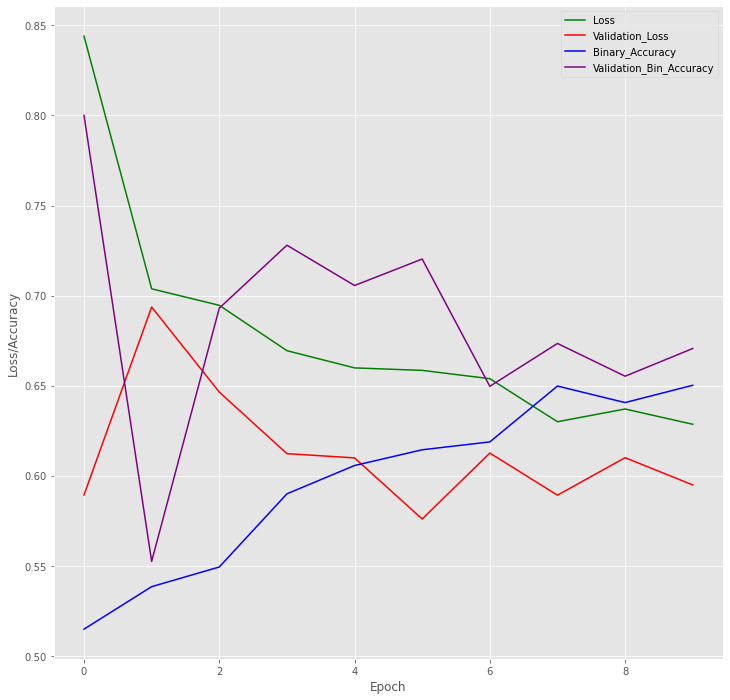

In [32]:
model3_plot = plot_history(history3,10)

In [33]:
history3_df=pd.DataFrame(history3.history)
performance.append(history3_df[history3_df['val_loss']==min(history3_df['val_loss'])])
performance

[       loss  binary_accuracy  val_loss  val_binary_accuracy
 8  0.657849         0.623581  0.560996             0.655245,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 3  0.697308         0.504803  0.535796             0.779021,
        loss  binary_accuracy  val_loss  val_binary_accuracy
 5  0.658476          0.61441  0.575997              0.72028]

### **Model 1** has the lowest val_loss. We will follow by using Model 1

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [34]:

def load_pretrained_model(layer_of_interest):
    
    model = VGG16(include_top = True, weights='imagenet')
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    for layer in vgg_model.layers[0:-2]:
        layer.trainable = False
    
    return vgg_model


In [35]:

def build_my_model(pretrained_model):
    "Add one Dense layer and one Dropout Layer"
    my_model = Sequential()
    my_model.add(pretrained_model)
    my_model.add(Flatten())
    
    # addition added Dense layer and Dropout layer
    my_model.add(Dense(2048, activation = 'relu'))
    my_model.add(Dropout(0.5))
    
    my_model.add(Dense(1024, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation = 'relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1, activation = 'sigmoid'))
    
    optimizer = Adam(learning_rate = 1e-3)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
     
    return my_model

In [36]:
vgg_model = load_pretrained_model('block5_pool')
my_model1 = build_my_model(vgg_model)
my_model1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 2048)              51382272  
_________________________________________________________________
dropout_11 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)              

In [37]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
# my_model.load_weights(weight_path)
# pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

weight_path="{}_my_model.best.hdf5".format('xray_class')

vgg_model = load_pretrained_model('block5_pool')
my_model1 = build_my_model(vgg_model)
my_model1.load_weights(weight_path)
val_gen.reset()
pred_Y = my_model1.predict(val_gen, verbose = True)   


45/45 [==============================] - 25s 547ms/step


In [38]:
pred_Y.shape

(1430, 1)

In [39]:
val_gen.labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [40]:
pred_Y = pred_Y.flatten().tolist()

In [41]:
predictions_df=pd.DataFrame({'Label':val_gen.labels,'Predict':pd.Series(pred_Y)})
predictions_df.sort_values('Label',ascending=False).head(10)

Label   Predict
0        1  0.497598
189      1  0.408657
195      1  0.488050
194      1  0.138935
193      1  0.500749
192      1  0.498714
191      1  0.414088
190      1  0.498714
188      1  0.498714
197      1  0.382133

In [42]:
predictions_df.to_csv('Predictions_best_model.csv')

In [43]:
predictions_df= pd.read_csv('Predictions_best_model.csv')
predictions_df

Unnamed: 0  Label   Predict
0              0      1  0.497598
1              1      1  0.492075
2              2      1  0.485877
3              3      1  0.487302
4              4      1  0.234990
...          ...    ...       ...
1425        1425      0  0.304827
1426        1426      0  0.500274
1427        1427      0  0.324961
1428        1428      0  0.099961
1429        1429      0  0.333770

[1430 rows x 3 columns]

## ROC, Precision-Recall Curve, F1 Score 

In [44]:
def plot_roc(t_y, p_y):
    
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label = 1)
    plt.plot(fpr,tpr)
    plt.style.use('ggplot')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',label='Chance', alpha=.8)
    plt.savefig('Output/ROC_Curve')
    plt.show()
    
    return fpr, tpr, thresholds

## what other performance statistics do you want to include here besides AUC? 


def plot_precision_recall_curve(t_y, p_y):
    precision, recall, threshold = precision_recall_curve(t_y,p_y,pos_label = 1)
    threshold = np.append(threshold, 1)
    plt.style.use('ggplot')
    plt.plot(precision, recall)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.savefig('Output/Precision_Recall_Curve')
    plt.show()
    
    return precision, recall, threshold

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_f1(t_y,p_y):
    precision, recall, threshold = plot_precision_recall_curve(t_y,p_y)
    f1 = calc_f1(precision, recall)
    plt.style.use('ggplot')
    plt.plot(threshold, f1)
    plt.title('F1 vs Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1')
    plt.savefig('Output/F1_Threshold')
    plt.show()
    
    return precision, recall, f1, threshold

def plot_auc(t_y, p_y):
    fig, ax = plt.subplots(figsize=(8,8))
    plt.style.use('ggplot')
    fpr, tpr, thresholds = plot_roc(t_y, p_y)
    res = auc(fpr, tpr)
    print("AUC-ROC is: " + str(res))
    return fpr, tpr, thresholds, res
    

### ROC curve

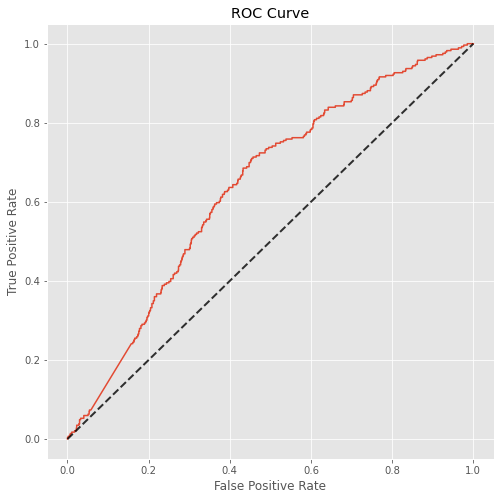

AUC-ROC is: 0.6367701354589467


In [45]:
fpr, tpr, thresholds_ROC, AUC = plot_auc(predictions_df['Label'],predictions_df['Predict'])

### Precision-Recall Curve

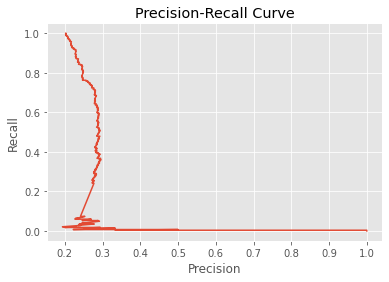

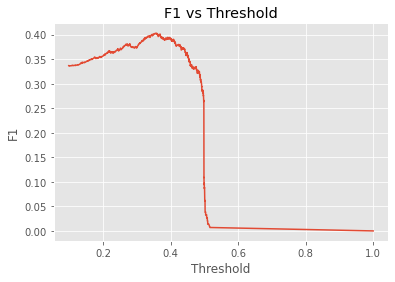

In [46]:
precision, recall, f1, thresholds_f1 = plot_f1(predictions_df['Label'],predictions_df['Predict'])

In [47]:
recall_df = pd.DataFrame({"Precision":precision, "Threshold":thresholds_f1, "Recall":recall, "F1":f1})

In [48]:
recall_df

Precision  Threshold    Recall        F1
0      0.202406   0.098410  1.000000  0.336669
1      0.201841   0.099745  0.996503  0.335689
2      0.201984   0.099961  0.996503  0.335887
3      0.202128   0.101185  0.996503  0.336085
4      0.202271   0.101592  0.996503  0.336283
...         ...        ...       ...       ...
1248   0.500000   0.513107  0.006993  0.013793
1249   0.333333   0.516533  0.003497  0.006920
1250   0.500000   0.518150  0.003497  0.006944
1251   1.000000   0.518218  0.003497  0.006969
1252   1.000000   1.000000  0.000000  0.000000

[1253 rows x 4 columns]

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [49]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

## If, this model can be used for screening studyies where High Recall is required, 
## reducing false negatives at the expense of more false positives.  This would 
## be found on the ROC curve where the distance away from Chance prediction is greatest.

def find_ROC_thresh(fpr,tpr,thresh):
    dist1=0
    dist2=0
    tprmax = 0
    for i in range(len(fpr)):
        dist2 = tpr[i] - fpr[i]
        if dist2 > dist1:
            dist1 = dist2
            tprmax=tpr[i]
        else:
            continue
    df = pd.DataFrame({'fpr':fpr,'tpr':tpr,'threshold':thresh})
    threshmax = df['threshold'][df['tpr']==tprmax].iloc[-1]
    return threshmax

## If this model is used for confirming a diagnosis, high precision is desired.
## An F1 Score is maximized where there is a balance between precision and recall.
## The corresponding threshold for that F1 Score should be chosen.

def find_F1_thresh(f1,thresh):
    df = pd.DataFrame({'f1':f1,'threshold':thresh})
    threshmax = df['threshold'][df['f1']==df['f1'].max()] .iloc[-1]
    return threshmax

In [50]:
thresh_ROC = find_ROC_thresh(fpr,tpr, thresholds_ROC)
print("thresh_ROC is " + str(thresh_ROC))

thresh_ROC is 0.3571741580963135


In [51]:
thresh_F1 = find_F1_thresh(f1, thresholds_f1)
print("Maximium F1-score is {} \nThreshhold for this F1-score is {}".format(str(np.nanmax(f1)), str(thresh_F1)))

Maximium F1-score is 0.4027777777777778 
Threshhold for this F1-score is 0.3585679531097412


In [52]:
val_gen_labels= pd.DataFrame(val_gen.labels)
val_Pos_labels= val_gen_labels[val_gen_labels[0] > 0]
val_Pos_labels
val_Pos_ind=val_Pos_labels.index
val_Pos_ind

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            276, 277, 278, 279, 280, 281, 282, 283, 284, 285],
           dtype='int64', length=286)

In [53]:
val_filenames = np.array(val_gen.filenames)
val_labels=np.array(val_gen.labels)

### ROC Threshold Confusion Matrix

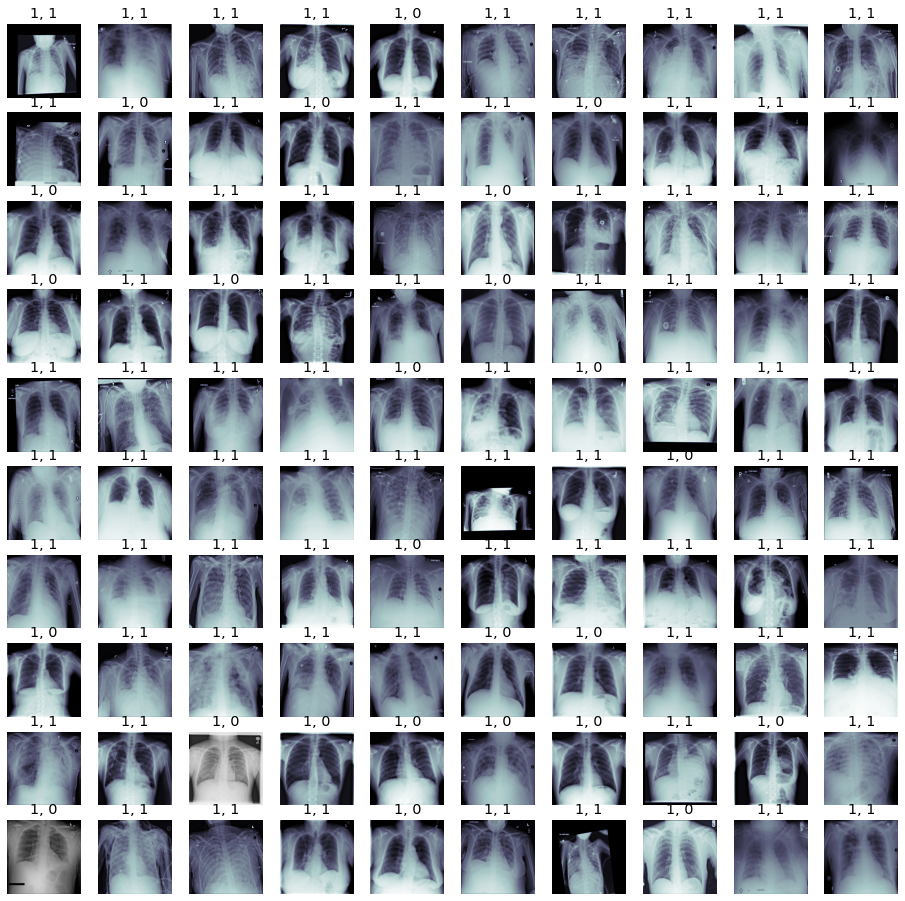

In [54]:
## Let's look at some examples of true vs. predicted with our best model based on thresh_ROC: 
from skimage.io import imread,imshow

Thresh=thresh_ROC

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_filenames[val_Pos_ind], val_labels[val_Pos_ind], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [55]:

pred_YROC = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_ROC:
        pred_YROC.append(1)
    else:
        pred_YROC.append(0)

tn,fp,fn,tp =confusion_matrix(val_gen.labels,pred_YROC).ravel()
print (tp, fp,"\n",fn,tn)

203 522 
 83 622


Optimize Threshold value by ROC is seen above. Based on images from the validation set with Positive Pneumonia labels, we see that the threshold value from ROC (0.357) identifies some Positive Pneumonia labels correctly. Based on it's corresponding confusion matrix, it yields 203 TP, 83 FN, 522 FP.

### F1 Threshold Confusion Matrix

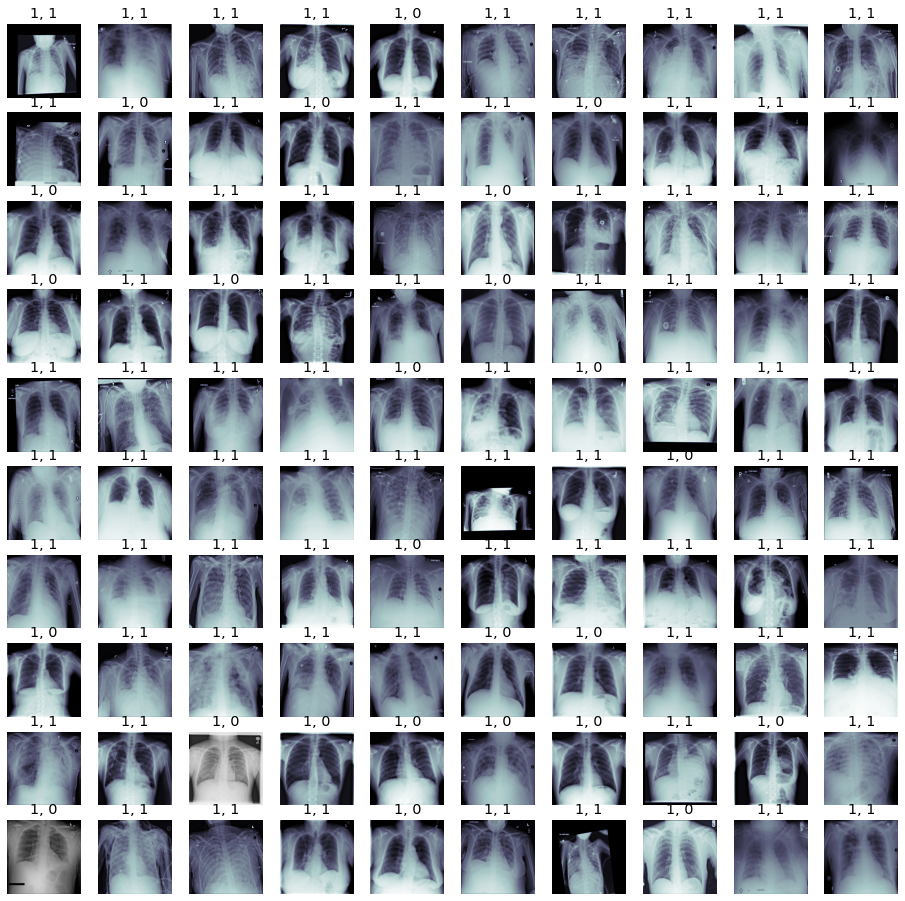

In [56]:
### F1 Threshold Confusion Matrix## Let's look at some examples of true vs. predicted with our best model based on thresh_F1: 
Thresh=thresh_F1

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_filenames[val_Pos_ind], val_labels[val_Pos_ind], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [57]:

pred_YF1 = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_F1:
        pred_YF1.append(1)
    else:
        pred_YF1.append(0)

tn,fp,fn,tp = confusion_matrix(val_gen.labels,pred_YF1).ravel()
print (tp, fp,"\n",fn,tn)

202 519 
 84 625


Optimize Threshold value by F1. Based on images from the validation set with Positive Pneumonia labels, we see that the threshold value from F1 (0.358) identifies some Positive Pneumonia labels correctly. Based on it's corresponding confusion matrix, it yields 202 TP and 84 FN, 519 FP. The performance is similar to optimizing by ROC. With this threshold, the F1 score is 0.403.

### Max Recall Confusion Matrix

In [58]:
### Max Recall Confusion Matrix#Maximize Recall.  Choose Threshold at recall at 0.8.
recall_df[recall_df['Recall']>0.8]

Precision  Threshold    Recall        F1
0     0.202406   0.098410  1.000000  0.336669
1     0.201841   0.099745  0.996503  0.335689
2     0.201984   0.099961  0.996503  0.335887
3     0.202128   0.101185  0.996503  0.336085
4     0.202271   0.101592  0.996503  0.336283
..         ...        ...       ...       ...
486   0.249191   0.279563  0.807692  0.380874
487   0.248380   0.279619  0.804196  0.379538
488   0.248649   0.279626  0.804196  0.379851
489   0.248918   0.279651  0.804196  0.380165
490   0.248104   0.279753  0.800699  0.378825

[491 rows x 4 columns]

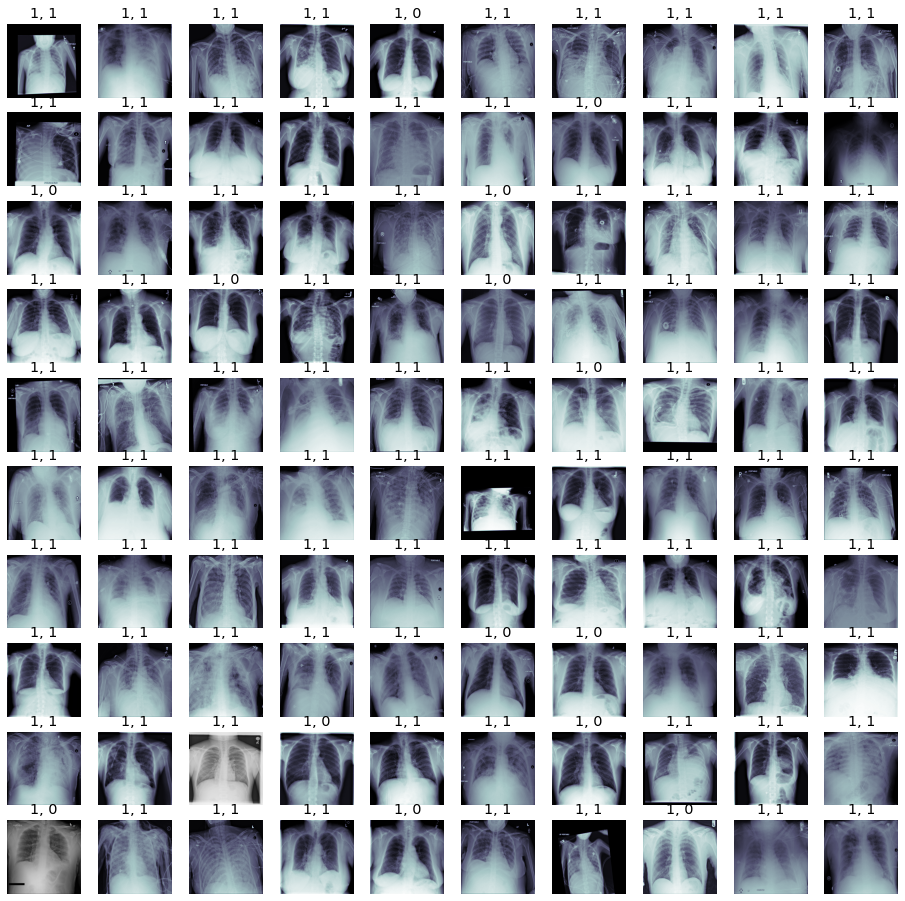

In [61]:
## Let's look at some examples of true vs. predicted with our best model maximizing Recall.  Recall=0.80: 
Thresh =  0.279

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(val_filenames[val_Pos_ind], val_labels[val_Pos_ind], m_axs.flatten()):
    c_ax.imshow(imread(c_x), cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > Thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > Thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [62]:

thresh_recall = 0.279

pred_Yrecall = []

for x in range(len(pred_Y)):
    if pred_Y[x] > thresh_recall:
        pred_Yrecall.append(1)
    else:
        pred_Yrecall.append(0)

tn,fp,fn,tp = confusion_matrix(val_gen.labels,pred_Yrecall).ravel()
print (tp, fp,"\n",fn,tn)

231 700 
 55 444


Maximize recall. A threshold value of 0.279 was chosen where Recall is above 0.80. It's corresponding confusion matrix, it yields 231 TP, 55 FN, with 700 FP. Though this method should have favored increasing TP at the cost of FN, this did not yield a result that is more aggressive that optimizing by ROC or F1.

In [63]:
## Just save model architecture to a .json:

model_json = my_model1.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)